In [50]:
using Pkg; Pkg.activate("."); Pkg.instantiate()

 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`


# 7 一般化線形混合モデル (GLMM) -個体差のモデリング-

In [51]:
using CSV
using DataFrames
using DataStructures
using Distributions
using GLM
using LaTeXStrings
using LinearAlgebra
using Plots
using QuadGK
using StatsBase
using Statistics
using MixedModels

## 7.1 例題 : GLMでは説明できないカウントデータ

In [52]:
df = CSV.read(joinpath("..", "data/section7.csv"))

,N,y,x,id
,Int64,Int64,Int64,Int64
1,8,0,2,1
2,8,1,2,2
3,8,2,2,3
4,8,4,2,4
5,8,1,2,5
6,8,0,2,6
7,8,0,2,7
8,8,7,2,8
9,8,1,2,9


In [53]:
df.N = convert(Array{Float64}, df.N)
df.yy = df.y ./ df.N
disallowmissing!(df)
categorical!(df, :id)

,N,y,x,id,yy
,Float64,Int64,Int64,Cat…,Float64
1,8.0,0,2,1,0.0
2,8.0,1,2,2,0.125
3,8.0,2,2,3,0.25
4,8.0,4,2,4,0.5
5,8.0,1,2,5,0.125
6,8.0,0,2,6,0.0
7,8.0,0,2,7,0.0
8,8.0,7,2,8,0.875
9,8.0,1,2,9,0.125


### データの図示
個体数をマーカーの大きさに反映させている

破線は「真の」生存確率の一例

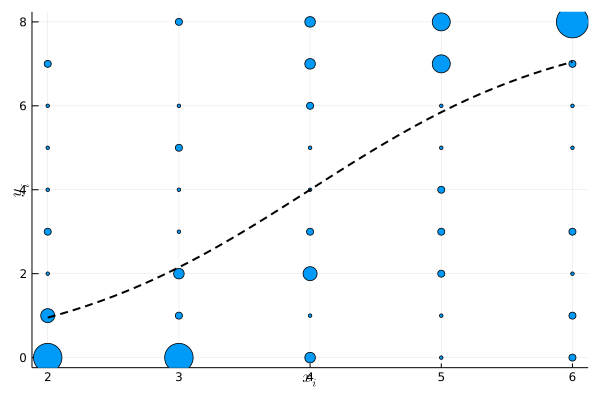

sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file


In [54]:
logistic(z) = 1 / (1 + exp(-z))

xs = 2:0.1:6
cols = [:x, :y]
df_plot = combine(groupby(df, cols), names(df, Not(cols)) .=> length)

scatter(df_plot.x, df_plot.y, markersize=df_plot.id_length .* 2, label="")
plot!(xs, mean.(Binomial.(8, logistic.(-4 .+ 1 .* xs))), label="",
    xlabel=L"x_i", ylabel=L"y_i",
    linestyle=:dash, linewidth=2, linecolor=:black)

### GLMを使ってデータから種子の生存確率を推定

In [55]:
glm_model = glm(@formula(yy ~ x), df, Binomial(), wts=df.N)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

yy ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error   z value  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  -2.14874    0.237235   -9.05744    <1e-18   -2.61372  -1.68377
x             0.510381   0.0556032   9.17898    <1e-19    0.4014    0.619361
────────────────────────────────────────────────────────────────────────────

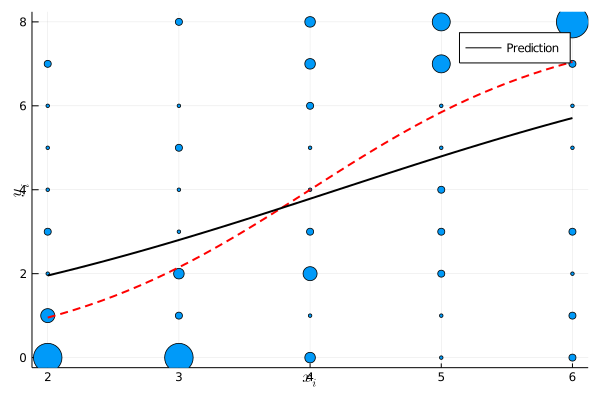

sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file


In [56]:
scatter(df_plot.x, df_plot.y, markersize=df_plot.id_length .* 2, label="",
    xlabel=L"x_i", ylabel=L"y_i")

plot!(xs, mean.(Binomial.(8, logistic.(-4 .+ 1 .* xs))), label="",
    linestyle=:dash, linewidth=2, linecolor=:red)

xx = DataFrame(x = xs)

plot!(xs, predict(glm_model, xx) .* 8,
    label="Prediction", linewidth=2, linecolor=:black)

### 葉数が4となるデータのサブセットを作る

In [57]:
d4 = df[df.x .== 4, :]

,N,y,x,id,yy
,Float64,Int64,Int64,Cat…,Float64
1,8.0,6,4,41,0.75
2,8.0,2,4,42,0.25
3,8.0,0,4,43,0.0
4,8.0,5,4,44,0.625
5,8.0,6,4,45,0.75
6,8.0,2,4,46,0.25
7,8.0,8,4,47,1.0
8,8.0,2,4,48,0.25
9,8.0,7,4,49,0.875


In [58]:
cols = [:x, :y]
d4_plot = combine(groupby(d4, cols), names(d4, Not(cols)) .=> length)

,x,y,N_length,id_length,yy_length
,Int64,Int64,Int64,Int64,Int64
1,4,6,2,2,2
2,4,2,4,4,4
3,4,0,3,3,3
4,4,5,1,1,1
5,4,8,3,3,3
6,4,7,3,3,3
7,4,4,1,1,1
8,4,3,2,2,2
9,4,1,1,1,1


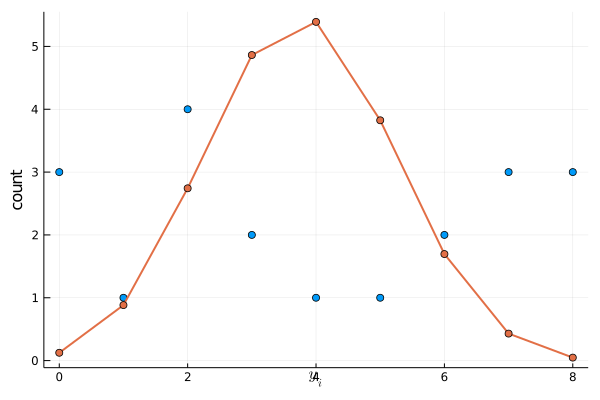

sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file


In [59]:
xs4 = 0:8
ys4 = pdf.(Binomial(8, 0.47), xs4) * 20
scatter(d4_plot.y, d4_plot.id_length, label="",
    xlabel=L"y_i", ylabel="count")
plot!(xs4, ys4, linewidth=2, label="", marker=4)

## 7.2 過分散と個体差¶
### 7.2.1 過分散 : ばらつきが大きすぎる
生存数ごとにカウントする

In [60]:
SortedDict(countmap(d4.y))

SortedDict{Int64,Int64,Base.Order.ForwardOrdering} with 9 entries:
  0 => 3
  1 => 1
  2 => 4
  3 => 2
  4 => 1
  5 => 1
  6 => 2
  7 => 3
  8 => 3

データの平均と分散を調べる

In [61]:
mean(d4.y), var(d4.y)

(4.05, 8.36578947368421)

### 7.4.1 Juliaを使ってGLMMのパラメーターを推定
MixedModels.jlを使う
https://juliastats.org/MixedModels.jl/latest/index.html

フィッティング結果は本文のものとは少し異なる。

$\hat{\beta}_1 = -4.19, \hat{\beta}_2 = 1.00, \hat{s}=2.41,$ residual deviance

In [62]:
glmm_model = fit(MixedModel, @formula(yy ~ x + (1 | id)), df, Binomial(); wts=df.N)

Generalized Linear Mixed Model fit by maximum likelihood (nAGQ = 1)
  yy ~ 1 + x + (1 | id)
  Distribution: Binomial{Float64}
  Link: LogitLink()

  Deviance: 269.4142

Variance components:
      Column   Variance Std.Dev. 
id (Intercept)  4.485268 2.117845

 Number of obs: 100; levels of grouping factors: 100

Fixed-effects parameters:
───────────────────────────────────────────────────
             Estimate  Std.Error   z value  P(>|z|)
───────────────────────────────────────────────────
(Intercept)  -4.18983   0.727666  -5.75791    <1e-8
x             1.00483   0.171586   5.8561     <1e-8
───────────────────────────────────────────────────

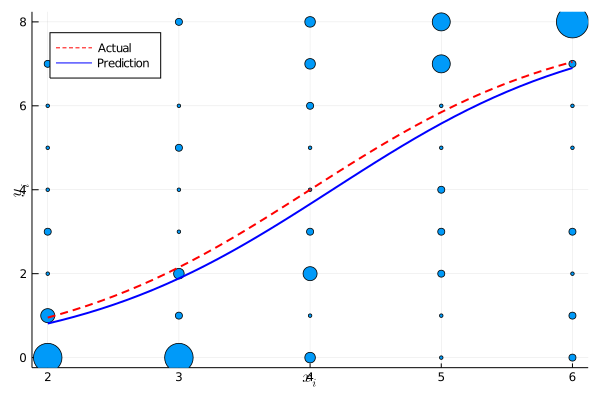

sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file


In [63]:
scatter(df_plot.x, df_plot.y, markersize=df_plot.id_length .* 2, label="",
    xlabel=L"x_i", ylabel=L"y_i", legend=:topleft)

plot!(xs, mean.(Binomial.(8, logistic.(-4 .+ 1 .* xs))),
    label="Actual",
    linestyle=:dash, linewidth=2, linecolor=:red)

plot!(xs, mean.(Binomial.(8, logistic.([fill(1, length(xs)) xs] * coef(glmm_model)))),
    label="Prediction", linewidth=2, linecolor=:blue)

In [64]:
Binomial(8, logistic(dot([1 4], coef(glmm_model))))

Binomial{Float64}(n=8, p=0.45747076701200107)

### 分布を混ぜる

In [65]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
    pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end

function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

### GLMMから予測された混合二項分布をプロットする

In [66]:
coef(glmm_model)

2-element Array{Float64,1}:
 -4.189829529312576
  1.0048251362725278

In [67]:
glmm_model.σs

(id = ((Intercept) = 2.117845176914375,),)

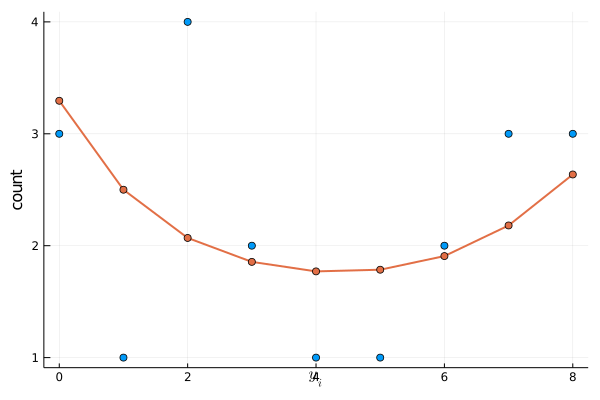

sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file


In [68]:
pdf_gaussian_binorm = d_gaussian_binorm.(0:8, dot([1 4], coef(glmm_model)), glmm_model.σs[1][1])
scatter(d4_plot.y, d4_plot.id_length, label="",
    xlabel=L"y_i", ylabel="count")
plot!(0:8, pdf_gaussian_binorm * 20, linewidth=2, marker=4, label="")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*